In [1]:
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
import tensorflow as tf

In [5]:
import time
import os,sys
import numpy as np
from PIL import Image
from matplotlib import pylab as plt

In [6]:
#時間計測の開始
start = time.time()

In [7]:
sess = tf.InteractiveSession()

In [10]:
#プレースホルダーにてTFに計算を依頼
x = tf.placeholder("float", shape=[None, 784]) 
y_ = tf.placeholder("float", shape=[None, 10])

## 重みの初期化

In [11]:
###############　多層畳み込みネットワークの構築　####################
# 重みの初期化　tf.truncated_nomalではランダムな数値で初期化
# 一般に少量のノイズでweightの初期値を決定することで、勾配消失問題や対称性の破れを防ぐ。
# 今回はReLUを用いるので、わずかに正のbiasを初期値として与えるのが役に立たない回路をなくす為には、同様に良い方法であろう。

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

## 畳み込みとプーリングの設定

In [12]:
# 畳み込みではゼロパディング(畳み込み後の出力と入力のサイズが同じになるようにする)を施し、ストライド1でフィルターを動かす。
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [14]:
# プーリングは2×2画素の最大プーリングとする。
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

## 第一畳み込み層（First Convolutional Layer）の設定

##### 5×5のフィルター32種を用いて1チャンネルの画像(1画素につき1つの値(おそらくグレースケール))を処理する。

In [24]:
# The first two dimensions are the patch size
# The next is the number of input channels, and the last is the number of output channels. 
W_conv1 = weight_variable( [5, 5, 1, 32] )

# We will also have a bias vector with a component for each output channel.
b_conv1 = bias_variable([32])

#### この層に適応させるために、入力画像のxを4dのテンソルに変形する。

In [19]:
# 2d,3dは画像のpx数で、4dは色のチャンネル数(グレースケールなので1), 1dは?
x_image = tf.reshape(x, [-1, 28, 28, 1])     

#### その後、x_imageを畳み込み、ReLU関数を作用させ、最後に最大プーリングする。

In [25]:
# We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool. 
# The max_pool_2x2 method will reduce the image size to 14x14.

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

## 第二畳み込み層（Second Convolutional Layer）の設定

#### 第二層では64の5×5フィルタを用い、64の特徴を計算する。

In [23]:
# The second layer will have 64 features for each 5x5 patch.
W_conv2 = weight_variable( [5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

## 全結合層（(Fully connected layers）の設定

#### ここまでに画像は7×7（それぞれの画素のチャンネルは64）まで減らされています。1024個の出力を行う全結合層（全ての入力と出力がニューロンで結びついている層）を作成する。

In [28]:
# Now that the image size has been reduced to 7x7, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. 
# We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

W_fc1 = weight_variable( [7*7*64, 1024] )
b_fc1 = bias_variable( [1024] )

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])                 # reshapeにてベクトルに戻す
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)       # 行列演算と重みを加算し活性化させる

## ドロップアウトの設定

#### 過学習を防ぐために、読みだし層の前にドロップアウトを適用する。

In [29]:
# ニューロンからの出力がドロップアウトの間保持される、確率を入れるためのplaceholderを用意する。
# これにより学習中にドロップアウトを行い、テスト中には行わないということが可能になる。

keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## 読み出し層（Readout Layer）の設定

In [32]:
# ソフトマックス関数を適用する。
W_fc2 = weight_variable( [1024, 10] )
b_fc2 = bias_variable( [10] )

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

## モデルの学習と評価（Train and Evaluate the Model）

#### for beginersとの違いはgradient descentでの最適化より洗練されたADAMでの最適化を行うことと、keep_prob(ドロップアウトのためのplaceholder)があることと、100回ごとにログを出すことと、2万回ループを回すことである。

In [33]:
# コスト関数'クロスエントロピー'の定義
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
#最急降下法の定義
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# 評価を行う(正解率の算出)
correct_predition = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predition, "float"))

# 初期化
sess.run(tf.global_variables_initializer())

for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%100 ==0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_:batch[1], keep_prob: 1.0})
        print("学習回数： %d 回, トレーニングの精度 %g"%(i, train_accuracy))
    train_step.run(feed_dict={x:batch[0], y_:batch[1], keep_prob:0.5})

学習回数： 0 回, トレーニングの精度 0.04
学習回数： 100 回, トレーニングの精度 0.78
学習回数： 200 回, トレーニングの精度 0.96
学習回数： 300 回, トレーニングの精度 0.94
学習回数： 400 回, トレーニングの精度 0.92
学習回数： 500 回, トレーニングの精度 0.9
学習回数： 600 回, トレーニングの精度 0.94
学習回数： 700 回, トレーニングの精度 0.96
学習回数： 800 回, トレーニングの精度 0.92
学習回数： 900 回, トレーニングの精度 0.98
学習回数： 1000 回, トレーニングの精度 0.94
学習回数： 1100 回, トレーニングの精度 0.98
学習回数： 1200 回, トレーニングの精度 1
学習回数： 1300 回, トレーニングの精度 0.96
学習回数： 1400 回, トレーニングの精度 0.96
学習回数： 1500 回, トレーニングの精度 1
学習回数： 1600 回, トレーニングの精度 0.98
学習回数： 1700 回, トレーニングの精度 0.96
学習回数： 1800 回, トレーニングの精度 0.98
学習回数： 1900 回, トレーニングの精度 1
学習回数： 2000 回, トレーニングの精度 0.96
学習回数： 2100 回, トレーニングの精度 0.98
学習回数： 2200 回, トレーニングの精度 1
学習回数： 2300 回, トレーニングの精度 0.96
学習回数： 2400 回, トレーニングの精度 0.96
学習回数： 2500 回, トレーニングの精度 0.96
学習回数： 2600 回, トレーニングの精度 0.96
学習回数： 2700 回, トレーニングの精度 0.98
学習回数： 2800 回, トレーニングの精度 0.92
学習回数： 2900 回, トレーニングの精度 1
学習回数： 3000 回, トレーニングの精度 1
学習回数： 3100 回, トレーニングの精度 0.98
学習回数： 3200 回, トレーニングの精度 0.98
学習回数： 3300 回, トレーニングの精度 1
学習回数： 3400 回, トレーニングの精度 0.96
学習回数： 3500 回, トレーニン

In [35]:
#学習結果の表示
print("この学習の正解率は %g です"%accuracy.eval(feed_dict={ x: mnist.test.images, y_:mnist.test.labels, keep_prob: 1.0}))

この学習の正解率は 0.9909 です


In [36]:
def img_recognition(filename):
    #グレースケールとして画像の読み込み
    img = Image.open(filename).convert('L')
    plt.imshow(img)
    #画像を28x28に変換
    img.thumbnail((28, 28))
    #フロート型の行列に変換
    img = np.array(img, dtype=np.float32)
    #黒0~255白の画像データをMNISTのデータと同じ白0~1黒に変える
    img = 1 - np.array(img / 255)
    img = img.reshape(1, 784)
    #学習データと読み込んだ数値との比較を行う
    p = sess.run(y_conv, feed_dict={x:img, y_: [[0.0] * 10], keep_prob: 0.5})[0]
    
      #最も可能性のある数字を表示
    print(filename+"の数字は")
    print(np.argmax(p))

./TestData/one.pngの数字は
1


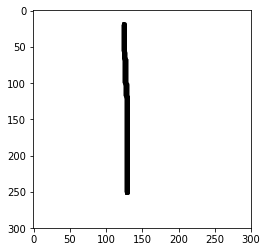

In [38]:
img_recognition("./TestData/one.png")

./TestData/two.pngの数字は
2


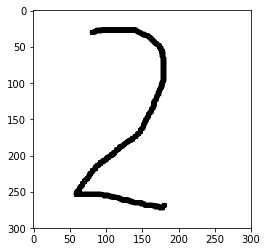

In [39]:
img_recognition("./TestData/two.png")

./TestData/three.pngの数字は
3


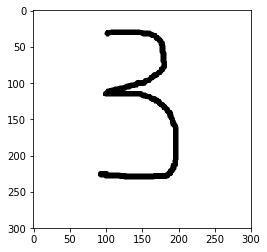

In [40]:
img_recognition("./TestData/three.png")

./TestData/four.pngの数字は
4


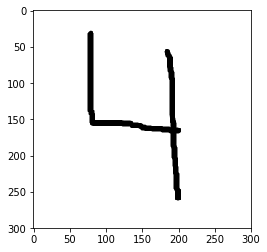

In [41]:
img_recognition("./TestData/four.png")

./TestData/five.pngの数字は
5


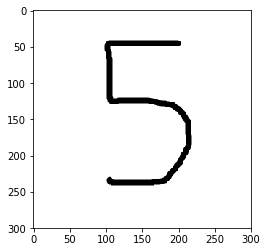

In [42]:
img_recognition("./TestData/five.png")

./TestData/six.pngの数字は
6


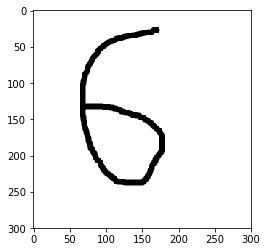

In [45]:
img_recognition("./TestData/six.png")

./TestData/seven.pngの数字は
7


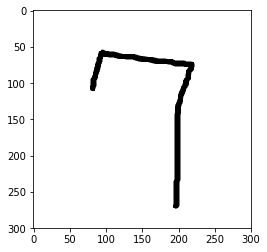

In [46]:
img_recognition("./TestData/seven.png")

./TestData/eight.pngの数字は
8


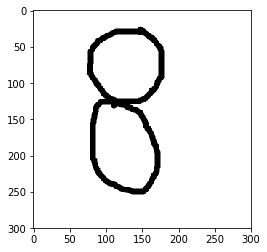

In [47]:
img_recognition("./TestData/eight.png")

./TestData/nine.pngの数字は
4


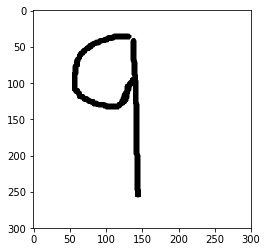

In [68]:
img_recognition("./TestData/nine.png")